In [45]:
!pip install capymoa

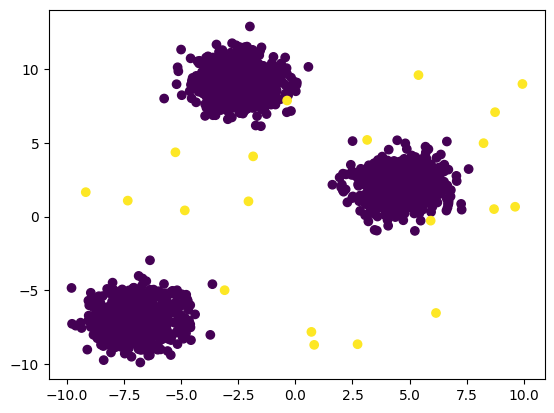

In [51]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from capymoa.stream import NumpyStream

# generate normal data points
n_samples = 2000
n_features = 2
n_clusters = 3
X, y = make_blobs(
    n_samples=n_samples, n_features=n_features, centers=n_clusters, random_state=42
)

# generate anomalous data points
n_anomalies = 20  # the anomaly rate is 1%
anomalies = np.random.uniform(low=-10, high=10, size=(n_anomalies, n_features))

# combine the normal data points with anomalies
X = np.vstack([X, anomalies])
y = np.hstack([y, [1] * n_anomalies])  # Label anomalies with 1
y[:n_samples] = 0  # Label normal points with 0

# shuffle the data
idx = np.random.permutation(n_samples + n_anomalies)
X = X[idx]
y = y[idx]

plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

# create a NumpyStream from the combined dataset
feature_names = [f"feature_{i}" for i in range(n_features)]
target_name = "class"

In [52]:
from capymoa.anomaly import HalfSpaceTrees, OnlineIsolationForest
from capymoa.evaluation import AnomalyDetectionEvaluator

stream_ad = NumpyStream(
    X,
    y,
    dataset_name="AnomalyDetectionDataset",
    feature_names=feature_names,
    target_name=target_name,
    target_type="categorical",
)

In [53]:
learners = {
    "HalfSpaceTrees": HalfSpaceTrees(stream_ad.get_schema()),
    "OnlineIsolationForest": OnlineIsolationForest(stream_ad.get_schema()),
}

In [54]:
# Higher AUC higher chance there is anomaly
# Manuel version of test than train in a stream
results = {}
for name, learner in learners.items():
    evaluator = AnomalyDetectionEvaluator(stream_ad.get_schema())

    # Reset stream for each learner
    stream_ad.restart()

    while stream_ad.has_more_instances():
        instance = stream_ad.next_instance()
        score = learner.score_instance(instance)   # anomaly score
        evaluator.update(instance.y_index, score) # compare with ground truth
        learner.train(instance)                   # update model

    auc = evaluator.auc()
    results[name] = auc
    print(f"{name} AUC: {auc:.2f}")

HalfSpaceTrees AUC: 0.94
OnlineIsolationForest AUC: 0.77


In [55]:
# Using autoencoder with pytorch
# prerequential version of test then train
from capymoa.anomaly import Autoencoder
from capymoa.evaluation import prequential_evaluation_anomaly

ae = Autoencoder(schema=stream_ad.get_schema(), hidden_layer=1)

results_ae = prequential_evaluation_anomaly(
    stream=stream_ad, learner=ae, window_size=1000
)

print(f"AUC: {results_ae.auc()}")

AUC: 0.53965
